In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import admix
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import dapgen
from os.path import join
import admix_genet_cor

In [ ]:
GENO_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01_dataset/out/aframr"
)

In [3]:
pfile = f"{GENO_DIR}/imputed/chr1"
geno, df_snp, df_indiv = dapgen.read_pfile(pfile, phase=True, snp_chunk=2048)
lanc = admix.io.read_lanc(pfile + ".lanc", snp_chunk=2048)
df_snp_info = pd.read_csv(pfile + ".snp_info", sep="\t").set_index("SNP")
assert np.all(df_snp_info.index == df_snp.index.values)
df_snp = pd.merge(df_snp, df_snp_info, left_index=True, right_index=True)

freq_filter = (
    (0.005 <= df_snp.EUR_FREQ)
    & (df_snp.EUR_FREQ <= 0.995)
    & (0.005 <= df_snp.AFR_FREQ)
    & (df_snp.AFR_FREQ <= 0.995)
)

geno = geno[freq_filter.values, :, :]
lanc = lanc[freq_filter.values, :, :]
df_snp = df_snp.iloc[freq_filter.values, :]

In [4]:
apa = admix.data.allele_per_anc(geno, lanc)
geno_cnt = geno.sum(axis=2)

In [5]:
window_size = 10000
step_size = 25
n_region = 30

In [6]:
np.random.seed(1234)
causal_snps = np.random.choice(df_snp.index, size=n_region, replace=False)
causal_idx = [df_snp.index.get_loc(s) for s in causal_snps]

df_cov_diff = {"cov_diff": [], "pos": [], "causal_snp": []}

for snp, idx in zip(causal_snps, causal_idx):
    region_idx = np.arange(idx - window_size, idx + window_size, step_size)
    df_cov_diff["cov_diff"].extend(
        admix_genet_cor.calc_apa_cov(
            apa[region_idx, :, :].compute(),
            geno_cnt[idx, :].compute(),
        )
    )
    # relative base pairs
    df_cov_diff["pos"].extend(
        (df_snp.POS.iloc[region_idx] - df_snp.POS.iloc[idx]).values
    )
    df_cov_diff["causal_snp"].extend([snp] * len(region_idx))
df_cov_diff = pd.DataFrame(df_cov_diff)

100%|██████████| 800/800 [00:01<00:00, 699.88it/s]


KeyboardInterrupt: 

In [8]:
df_cov_diff = pd.DataFrame(df_cov_diff)

In [22]:
df_plot = df_cov_diff.copy()
# convert to Mb
df_plot["pos"] /= 1e6
df_plot["abs_pos"] = np.abs(df_plot["pos"])
df_plot["squared_cov_diff"] = df_plot["cov_diff"] ** 2
# df_plot = df_plot[df_plot.abs_pos < 6]

In [23]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [24]:
model = smf.quantreg(
    "squared_cov_diff ~ abs_pos + I(abs_pos ** 2.0) + I(abs_pos ** 3.0) ", df_plot
).fit(q=0.95)

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Text(0.5, 0, 'Distance (Mb)')

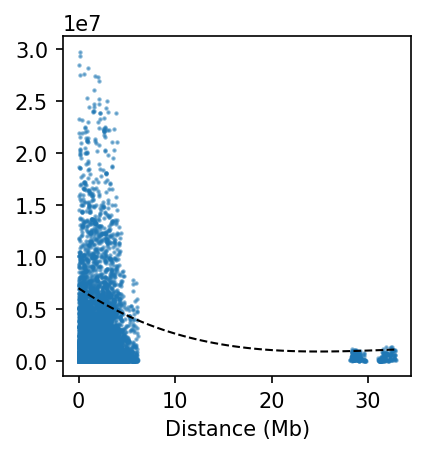

In [25]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(
    df_plot.abs_pos,
    df_plot.squared_cov_diff,
    marker=".",
    alpha=0.5,
    s=5,
)
x_grid = np.linspace(0, df_plot.abs_pos.max(), 50)


plt.plot(
    x_grid,
    model.predict({"abs_pos": x_grid}),
    linestyle="--",
    lw=1,
    color="k",
    zorder=2,
)
ax.set_xlabel("Distance (Mb)")

In [3]:
# select a 10 Mb region
# simulate a single causal (with expected p-value of 1e-10)
# perform study

In [217]:
# causal_snp = "chr1:109593836:A:G"
# causal_snp = "chr1:11472468:C:G"
causal_snp = "chr1:229573921:C:A"
hsq = 0.005

In [218]:
def submit_simulate_pheno(
    hsq,
    causal_snp,
    region_window=500,
    #     out_prefix: str,
    #     n_sim=10,
):
    """
    hsq: heritability of the causal SNPs.
    causal_snp: index of the causal SNP
    region_window: window size in Mb
    """
    np.random.seed(0)
    pfile = f"{GENO_DIR}/imputed/chr1"
    geno, df_snp, df_indiv = dapgen.read_pfile(pfile, phase=True, snp_chunk=2048)
    lanc = admix.io.read_lanc(pfile + ".lanc", snp_chunk=2048)
    df_snp_info = pd.read_csv(pfile + ".snp_info", sep="\t").set_index("SNP")
    assert np.all(df_snp_info.index == df_snp.index.values)
    df_snp = pd.merge(df_snp, df_snp_info, left_index=True, right_index=True)

    # determine subset of SNPs
    causal_idx = df_snp.index.get_loc(causal_snp)

    region_snp_idx = np.arange(
        causal_idx - region_window, causal_idx + region_window + 1
    )
    df_tmp = df_snp.iloc[region_snp_idx, :]
    freq_filter = (
        (0.005 <= df_tmp.EUR_FREQ)
        & (df_tmp.EUR_FREQ <= 0.995)
        & (0.005 <= df_tmp.AFR_FREQ)
        & (df_tmp.AFR_FREQ <= 0.995)
    )
    region_snp_idx = region_snp_idx[freq_filter]

    geno = geno[region_snp_idx, :, :]
    lanc = lanc[region_snp_idx, :, :]
    df_snp = df_snp.iloc[region_snp_idx, :]

    n_eff_snp = df_snp.shape[0]

    beta = np.zeros((n_eff_snp, 2, 1))  # (n_snp, n_anc, n_sim)
    causal_idx = df_snp.index.get_loc(causal_snp)

    beta[causal_idx, :, :] = 1.0

    sim = admix_genet_cor.simulate_quant_pheno(
        geno=geno, lanc=lanc, hsq=hsq, beta=beta, n_sim=1
    )
    pheno = sim["pheno"].flatten()
    df_rls = admix_genet_cor.marginal_het(
        geno=geno,
        lanc=lanc,
        y=pheno,
    )

    # calculate covariance
    apa = admix.data.allele_per_anc(geno, lanc, n_anc=2).compute()
    geno_cnt = geno.sum(axis=2).compute()

    df_rls["cov_diff_z"] = admix_genet_cor.calc_apa_cov(apa, geno_cnt[causal_idx, :])

    df_rls["total_cov"] = admix_genet_cor.calc_cov(
        geno_cnt, geno_cnt[[causal_idx], :]
    ).flatten()

    df_rls["assoc_pval"] = admix.assoc.marginal_fast(
        geno=geno, lanc=lanc, pheno=pheno, cov=None
    )
    causal_mask = np.full(df_rls.shape[0], False, dtype=bool)
    causal_mask[causal_idx] = True
    df_rls["causal"] = causal_mask
    #     return df_rls

    return df_rls, df_snp, apa, pheno

In [219]:
df_rls, df_snp, apa, pheno = submit_simulate_pheno(hsq=0.05, causal_snp=causal_snp)

100%|██████████| 344/344 [00:00<00:00, 709.26it/s]


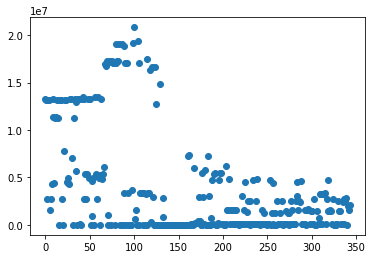

In [220]:
plt.scatter(np.arange(len(df_rls)), df_rls["cov_diff_z"] ** 2)

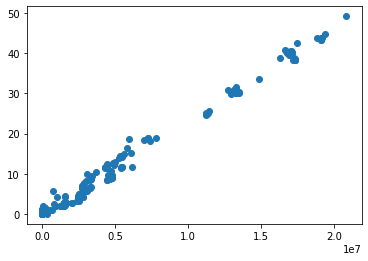

In [222]:
plt.scatter(df_rls["cov_diff_z"] ** 2, -np.log10(df_rls["het_pval"]))

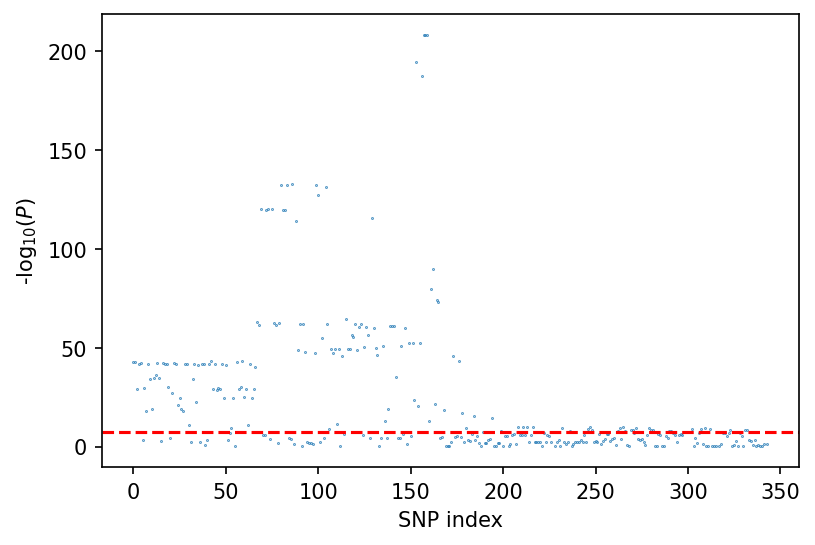

In [224]:
fig, ax = plt.subplots(dpi=150)
admix.plot.manhattan(df_rls.assoc_pval)

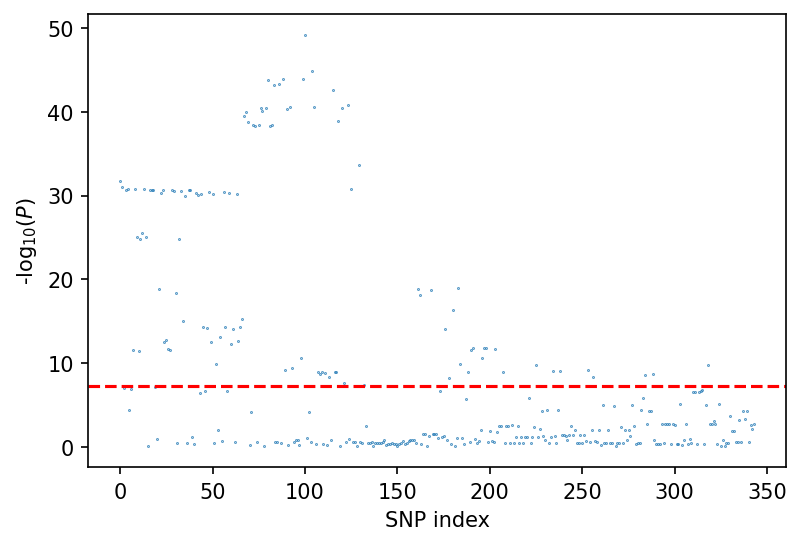

In [225]:
fig, ax = plt.subplots(dpi=150)
admix.plot.manhattan(df_rls.het_pval)

In [121]:
df_rls[df_rls["causal"]]

,het_pval,coef1,se1,coef2,se2,cov_diff_z,total_cov,assoc_pval,causal
57,0.66792,0.128966,0.015731,0.119797,0.016811,7.667304e-12,0.375205,2.900806e-24,True


In [ ]:
n_snp = apa.shape[0]
assert apa.shape[1] == m.shape[0]
# center apa
apa = apa - apa.mean(axis=0)[None, :, :]
m = m - m.mean()

z_list = np.zeros(n_snp)
# for each snp, calculate the covariance
transform_vec = np.array([[1], [-1]])
for snp_i in range(apa.shape[0]):
    cov_inv = np.linalg.inv(np.cov(apa[snp_i, :, :]))
    # expectation and variance
    ex = cov_inv @ apa[snp_i, :, :].T @ m
    varcov = cov_inv
    z_list[snp_i] = (ex[0] - ex[1]) / np.sqrt(transform_vec @ varcov @ transform_vec.T)
return z_list

In [ ]:
def calc_apa_cov(apa, m):
    # apa: (n_snp, n_indiv, 2)
    # m: (n_indiv, )


In [269]:
df_rls = submit_simulate_pheno(hsq=0.02, causal_snp=causal_snp)

100%|██████████| 137/137 [00:01<00:00, 134.95it/s]


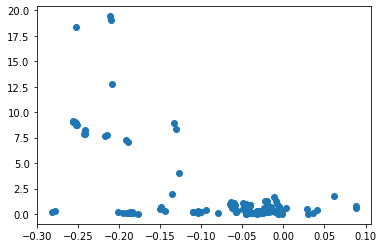

In [256]:
plt.scatter(df_rls.cov1 - df_rls.cov2, -np.log10(df_rls.het_pval))

In [ ]:
tmp_snp = [causal_idx, 62]
tmp_apa = apa[62, :, :]

In [264]:
df_rls.iloc[62, :]

het_pval      0.599686
coef1        -0.166931
se1           0.011382
coef2        -0.178054
se2           0.022366
cov1         -0.301997
cov2         -0.020244
total_cov    -0.322241
assoc_pval         0.0
causal            True
Name: 62, dtype: object

In [ ]:
tmp_apa.shape

In [72]:
# df_pheno = pd.DataFrame(
#     sim["pheno"],
#     index=df_indiv.index,
#     columns=[f"SIM_{i}" for i in range(n_sim)],
# )
# df_pheno.to_csv(out_prefix + ".pheno.tsv.gz", index=True, sep="\t")

In [ ]:
def submit_gwas(prefix, sim_i):

    df_sample_info = pd.read_csv(
        join(SIM_PHENO_DIR, prefix + ".pheno.tsv.gz"), sep="\t", index_col=0
    )
    out_prefix = f"out/simulated_gwas/{prefix}.sim_{sim_i}"

    admix.tools.plink2.gwas(
        pfile=join(GENO_DIR, f"imputed/chr1"),
        df_sample_info=df_sample_info,
        pheno_col=f"SIM_{sim_i}",
        out_prefix=out_prefix,
        clean_tmp_file=True,
    )
    admix.tools.plink2.clump(
        pfile=join(GENO_DIR, f"imputed/chr1"),
        assoc_path=out_prefix + ".assoc",
        out_prefix=out_prefix,
        p1=5e-8,
    )
    df_sample_info[[f"SIM_{sim_i}"]].rename(columns={f"SIM_{sim_i}": "trait"}).to_csv(
        out_prefix + ".pheno", sep="\t"
    )

In [ ]:
def submit_gwas(prefix, sim_i):

    df_sample_info = pd.read_csv(
        join(SIM_PHENO_DIR, prefix + ".pheno.tsv.gz"), sep="\t", index_col=0
    )
    out_prefix = f"out/simulated_gwas/{prefix}.sim_{sim_i}"

    admix.tools.plink2.gwas(
        pfile=join(GENO_DIR, f"imputed/chr1"),
        df_sample_info=df_sample_info,
        pheno_col=f"SIM_{sim_i}",
        out_prefix=out_prefix,
        clean_tmp_file=True,
    )
    admix.tools.plink2.clump(
        pfile=join(GENO_DIR, f"imputed/chr1"),
        assoc_path=out_prefix + ".assoc",
        out_prefix=out_prefix,
        p1=5e-8,
    )
    df_sample_info[[f"SIM_{sim_i}"]].rename(columns={f"SIM_{sim_i}": "trait"}).to_csv(
        out_prefix + ".pheno", sep="\t"
    )